# Gaussian Process Regression
## Marginal Likelihood

* Hermes issue 31
* Based on K. Murphy's [matlab code](https://github.com/probml/pmtk3/blob/master/demos/gprDemoMarglik.m)
* See also [PR request](https://github.com/probml/pyprobml/pull/352)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, slogdet
from scipy.optimize import minimize

In [2]:
np.set_printoptions(suppress=True, precision=5, linewidth=100)

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [4]:
x = np.array([-1.3089, 6.7612, 1.0553, -1.1734, -2.9339, 7.2530, -6.5843])[:, None]
y = np.array([1.6218, 1.8558, 0.4102, 1.2526, -0.0133, 1.6380, 0.2189])[:, None]

xstar = np.linspace(-7.5, 7.5, 201)

### Predictive Posterior

In [5]:
def k(u, v, sigma_f, l=1):
    return sigma_f ** 2 * np.exp(-(u - v) ** 2 / (2 * l ** 2))

def gp_predictive_post(xstar, x, y, k, sigma_y, *args, **kwargs):
    n, _ = x.shape
    kstar = k(x, xstar.T, *args, **kwargs)
    Kxx = k(x, x.T, *args) + sigma_y ** 2 * np.eye(n)
    kxx_star = k(xstar, xstar.T, *args, **kwargs)
    Kxx_inv = inv(Kxx)
    ystar = kstar.T @ Kxx_inv @ y
    Sigma_post = kxx_star - kstar.T @ Kxx_inv @ kstar
    
    return ystar, Sigma_post

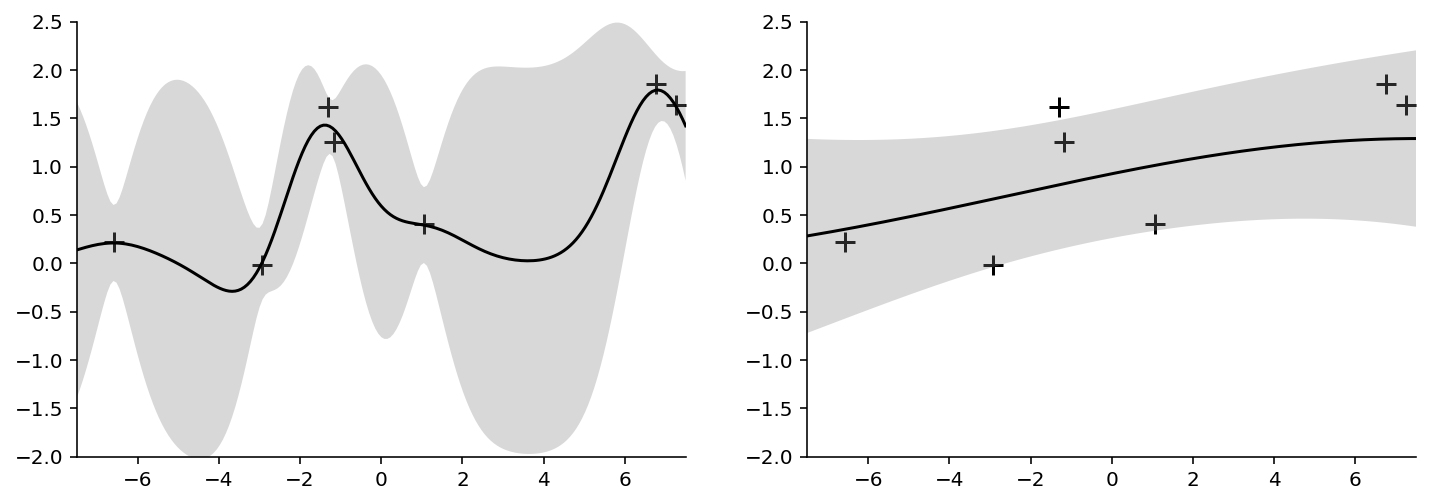

In [6]:
sigma_f=1.0
configs = [(1.0, 0.2), (10, 0.8)]
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for ax, (l, sigma_y) in zip(axs, configs):
    ystar, Sigma_post = gp_predictive_post(xstar, x, y, k, sigma_y, sigma_f, l)
    upper_bound = ystar.ravel() + 2 * np.sqrt(np.diag(Sigma_post))
    lower_bound = ystar.ravel() - 2 * np.sqrt(np.diag(Sigma_post))
    
    ax.scatter(x, y, marker="+", s=100, c="black")
    ax.plot(xstar, ystar, c="black")
    ax.fill_between(xstar.ravel(), lower_bound, upper_bound, color="tab:gray", alpha=0.3, edgecolor="none")
    ax.set_xlim(-7.5, 7.5)
    ax.set_ylim(-2, 2.5)

### Marginal log-likelihood

In [7]:
def log_likelihood(x, y, sigma_f, l, sigma_y):
    n, m = x.shape
    x = x / np.exp(l)
    Kxx = k(x, x.T, sigma_f) + np.exp(2 * sigma_y) * np.eye(n)
    s, DKxx = slogdet(Kxx)
    l = -1/2 * (y.T @ inv(Kxx) @ y + DKxx + n * np.log(2 * np.pi))
    return l.item()

In [8]:
def plot_marginal_likelihood_surface(x, y, sigma_f, l_space, sigma_y_space, ax, levels=None):
    P = np.stack(np.meshgrid(l_space, sigma_y_space), axis=0)
    Z = np.apply_along_axis(lambda p: log_likelihood(x, y, sigma_f, *p), 0, P)
    ax.contour(*np.exp(P), Z, levels=levels)
    ax.set_xlabel("characteristic length scale")
    ax.set_ylabel("noise standard deviation")
    ax.set_xscale("log")
    ax.set_yscale("log")

#### Finding local maximum

In [9]:
w01 = np.array([np.log(1), np.log(0.1)])
w02 = np.array([np.log(10), np.log(0.8)])

s0 = minimize(lambda p: -log_likelihood(x, y, sigma_f, *p), w01)
s1 = minimize(lambda p: -log_likelihood(x, y, sigma_f, *p), w02)

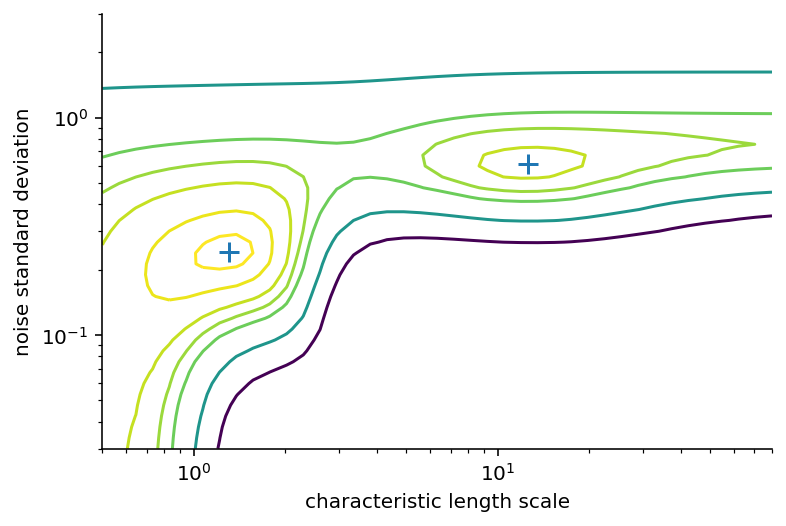

In [10]:
ngrid = 41
levels = -np.array([8.3, 8.5, 8.9, 9.3, 9.8, 11.5, 15])[::-1]
l_space = np.linspace(np.log(0.5), np.log(80), ngrid)
sigma_y_space = np.linspace(np.log(0.03), np.log(3), ngrid)


fig, ax = plt.subplots()
plot_marginal_likelihood_surface(x, y, sigma_f, l_space, sigma_y_space, ax, levels=levels)
plt.scatter(*np.exp(s0.x), marker="+", s=100, c="tab:blue")
plt.scatter(*np.exp(s1.x), marker="+", s=100, c="tab:blue")